#### Function to build a capacitive coupler for many qubits

In [1]:
import numpy as np 
import gdspy
from qnldraw import plot 

<img src="coupledcap_params.png" width=400 height=400 />

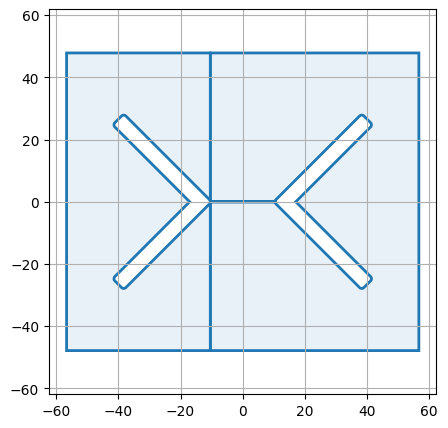

In [16]:
class MultiCoupler: 
    def __init__(self, xy, lx, ly, middle_gap, pad_gap, side_gap): 

        """
        Creates a diagonal-cross capacitive coupler design with customizable gaps and widths

        Parameters: 
        -----------
        xy (tuple): the center of the capacitive coupler
        lx (float): the diagonal-width of an electrode
        ly (float): the diagonal_length of half an electrode

        middle_gap (float): horizontal separation between electrodes
        pad_gap (float):    vertical padding between edges of bounding 
                            box and closest ends of the coupler
        side_gap (float):   horizontal padding between edges of bounding
                            box and middle corners of the coupler

        """

        self.xy = xy
        self.lx = lx
        self.ly = ly
        self.middle_gap = middle_gap
        self.pad_gap = pad_gap
        self.side_gap = side_gap 

    def rectangle_quadrant(self): 
        ## define top-left quadrant of coupler ##
        # counter clockwise rotation
        dx = (self.lx + self.ly) / (2 * np.sqrt(2)) + self.middle_gap/2
        dy = (self.ly - self.lx) / (2 * np.sqrt(2)) 
        def rotation(x, y, angle=np.pi/4): 
            x_rot = x * np.cos(angle) - y * np.sin(angle)
            y_rot = x * np.cos(angle) + y * np.sin(angle)
            return x_rot-dx, y_rot+dy
        
        x_center, y_center = self.xy
        rect_points = [
            (x_center - self.lx / 2, y_center - self.ly / 2),  # bottom-left
            (x_center + self.lx / 2, y_center - self.ly / 2),  # bottom-right
            (x_center + self.lx / 2, y_center + self.ly / 2),  # top-right
            (x_center - self.lx / 2, y_center + self.ly / 2)   # top-left
        ]
        # translate points to the origin
        translated_points = [(x - x_center, y - y_center) for x, y in rect_points]
        # rotate points
        rotated_points = [rotation(x, y) for x, y in translated_points]
        # translate points back
        translated_points = [(x + x_center, y + y_center) for x, y in rotated_points]

        max_point = max(translated_points, key=lambda point: point[0])
        pivot = (max_point[0]-self.lx/2, max_point[1])

        return gdspy.Polygon(translated_points).fillet(radius=[1]), pivot
    
    def symmetric_coupler(self): 
        ## use symmetry to define all four quadrants ##
        upper_left_quad, pivot = self.rectangle_quadrant()
        upper_right_quad = gdspy.copy(upper_left_quad).mirror(self.xy, [self.xy[0], self.xy[1]+1])
        bottom_left_quad = gdspy.copy(upper_left_quad).mirror(pivot, [pivot[0]-1, pivot[1]])
        bottom_right_quad = gdspy.copy(bottom_left_quad).mirror(self.xy, [self.xy[0], self.xy[1]+1])

        full_shape = gdspy.boolean([upper_left_quad,
                                    bottom_left_quad, 
                                    upper_right_quad, 
                                    bottom_right_quad], None, 'or')
        return full_shape
    
    def bounding_box(self):
        ## create bounding box based on provided gaps ##  
        full_shape = self.symmetric_coupler() 
        bbox = full_shape.get_bounding_box() 
        min_x, max_x = bbox[:, 0].min(), bbox[:, 0].max()
        min_y, max_y = bbox[:, 1].min(), bbox[:, 1].max()

        bottom_corner = ( 
            min_x + (self.ly - self.lx)/np.sqrt(2) - self.side_gap, 
            min_y - self.pad_gap
        )
        top_corner = (
            max_x - (self.ly - self.lx)/np.sqrt(2) + self.side_gap, 
            max_y + self.pad_gap
        )

        # mounting pad 
        encapsulating_rec = gdspy.Rectangle(bottom_corner, top_corner)
        cutout = gdspy.boolean(
            encapsulating_rec,
            full_shape, 
            operation='not'
        )

        return cutout
    
xy = (0,0)
lx, ly = 5, 40
middle_gap, pad_gap, side_gap = 20, 20, 40

class_ = MultiCoupler(xy=xy, 
                      lx=lx, ly=ly, 
                      middle_gap=middle_gap, pad_gap=pad_gap, side_gap=side_gap)
bbox = class_.bounding_box()
fig = plot(bbox)

gdspy.current_library = gdspy.GdsLibrary()

cell = gdspy.current_library.new_cell('COUPLER')
cell.add(bbox)

# export to gds
gdspy.current_library.write_gds('coupled_cap.gds');

- make josephson array parameters into a class with adjustable parameters for all circuit components
- thickness of electrode and lower electrode w/ controllable thickness. make lowest two arrays just one box. 
- fluxonium-check1-0.gds, have undercut along the electrode, but not on the lower triangle. 
